In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
from imutils import paths
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load and preprocess the images
imagePaths = sorted(list(paths.list_images("path_to_training_data_folder")))
random.seed(42)
random.shuffle(imagePaths)

In [40]:
data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(label)

# Convert data and labels to numpy arrays and normalize
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print(f"{len(imagePaths)} images ({data.nbytes / (1024 * 1000.0):.2f}MB)")

917 images (1078.39MB)


In [41]:
# Encode labels as binary arrays
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print(f"{i + 1}. {label}")

class labels:
1. Black Spot
2. Downy Mildew
3. Fresh Leaf


In [42]:
# Define the MobileNetV2 model function
def MobileNetV2_model(input_shape, class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False

    # Build the model on top of baseModel
    x = baseModel.output
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(class_number, activation='softmax')(x)

    # Create the model
    model = Model(inputs=baseModel.input, outputs=x)
    return model

In [43]:
# Set hyperparameters and compile the model
bs = 32
lr = 0.0001
input_shape = (224, 224, 3)
epochs = 20
class_number = len(mlb.classes_)

model = MobileNetV2_model(input_shape, class_number)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,182,539 (31.21 MB)

 Trainable params: 6,337,355 (24.18 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [44]:
# Split the data into training and testing sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=42)

In [45]:
# Train the model
print("[INFO] training the model...")
H = model.fit(
    trainX, trainY,
    batch_size=bs,
    steps_per_epoch=len(trainX) // bs,
    validation_data=(testX, testY),
    validation_steps=len(testX) // bs,
    epochs=epochs,
    verbose=1
)

[INFO] training the model...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.4844 - loss: 2.7591 - val_accuracy: 0.7250 - val_loss: 0.6460
Epoch 2/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.6897 - loss: 1.1335

2024-12-01 21:39:11.128714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6897 - loss: 1.1335 - val_accuracy: 0.8750 - val_loss: 0.3231
Epoch 3/20


2024-12-01 21:39:11.353247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 651ms/step - accuracy: 0.7492 - loss: 0.8005 - val_accuracy: 0.8125 - val_loss: 0.4497
Epoch 4/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 14s 704ms/step - accuracy: 0.9310 - loss: 0.4564

2024-12-01 21:39:26.250902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9310 - loss: 0.4564 - val_accuracy: 0.8750 - val_loss: 0.2325
Epoch 5/20


2024-12-01 21:39:26.691589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 968ms/step - accuracy: 0.8146 - loss: 0.6342 - val_accuracy: 0.8062 - val_loss: 0.4399
Epoch 6/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.8276 - loss: 0.7577

2024-12-01 21:39:50.345684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8276 - loss: 0.7577 - val_accuracy: 0.9167 - val_loss: 0.2262
Epoch 7/20


2024-12-01 21:39:50.570957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.8929 - loss: 0.3300 - val_accuracy: 0.9125 - val_loss: 0.2709
Epoch 8/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.8276 - loss: 0.3015

2024-12-01 21:40:01.632273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8276 - loss: 0.3015 - val_accuracy: 0.9167 - val_loss: 0.1879
Epoch 9/20


2024-12-01 21:40:01.984868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.8877 - loss: 0.2822 - val_accuracy: 0.8875 - val_loss: 0.4227
Epoch 10/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.8621 - loss: 0.3153

2024-12-01 21:40:12.249089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8621 - loss: 0.3153 - val_accuracy: 0.9167 - val_loss: 0.1411
Epoch 11/20


2024-12-01 21:40:12.453445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.9289 - loss: 0.2131 - val_accuracy: 0.9688 - val_loss: 0.1605
Epoch 12/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - accuracy: 0.8966 - loss: 0.2571

2024-12-01 21:40:23.281840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8966 - loss: 0.2571 - val_accuracy: 0.9167 - val_loss: 0.1243
Epoch 13/20


2024-12-01 21:40:23.499097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.9302 - loss: 0.2244 - val_accuracy: 0.9375 - val_loss: 0.1820
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.9167 - val_loss: 0.1939
Epoch 15/20


2024-12-01 21:40:32.216087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-01 21:40:32.387483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9470 - loss: 0.1307 - val_accuracy: 0.9563 - val_loss: 0.2564
Epoch 16/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 1.0000 - loss: 0.0332

2024-12-01 21:40:40.521759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-01 21:40:40.708525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0332 - val_accuracy: 0.9167 - val_loss: 0.2506
Epoch 17/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9789 - loss: 0.0549 - val_accuracy: 0.9625 - val_loss: 0.2311
Epoch 18/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.9310 - loss: 0.1741

2024-12-01 21:40:48.766387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9310 - loss: 0.1741 - val_accuracy: 0.9167 - val_loss: 0.3558
Epoch 19/20


2024-12-01 21:40:48.991891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.9855 - loss: 0.0417 - val_accuracy: 0.9375 - val_loss: 0.2776
Epoch 20/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.9655 - loss: 0.0952

2024-12-01 21:40:57.272475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9655 - loss: 0.0952 - val_accuracy: 0.9167 - val_loss: 0.3148


2024-12-01 21:40:57.479990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [46]:
# Evaluate the model and print the accuracy
print("[INFO] evaluating network...")
loss, accuracy = model.evaluate(testX, testY, batch_size=bs, verbose=1)
print(f"[INFO] Test accuracy: {accuracy * 100:.2f}%")

[INFO] evaluating network...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.9349 - loss: 0.2866
[INFO] Test accuracy: 93.48%


In [47]:
# Make predictions on the test set
predIdxs = model.predict(testX, batch_size=bs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step


In [48]:
# Convert predictions to label indices
predIdxs = np.argmax(predIdxs, axis=1)
testY_indices = np.argmax(testY, axis=1)

In [49]:
# Print the classification report
print(classification_report(testY_indices, predIdxs, target_names=mlb.classes_))

              precision    recall  f1-score   support

  Black Spot       0.88      0.95      0.91        66
Downy Mildew       1.00      0.97      0.99        36
  Fresh Leaf       0.96      0.90      0.93        82

    accuracy                           0.93       184
   macro avg       0.95      0.94      0.94       184
weighted avg       0.94      0.93      0.94       184



In [50]:
#Save the model
model.save('Plant_Disease_Detection_Model.keras')

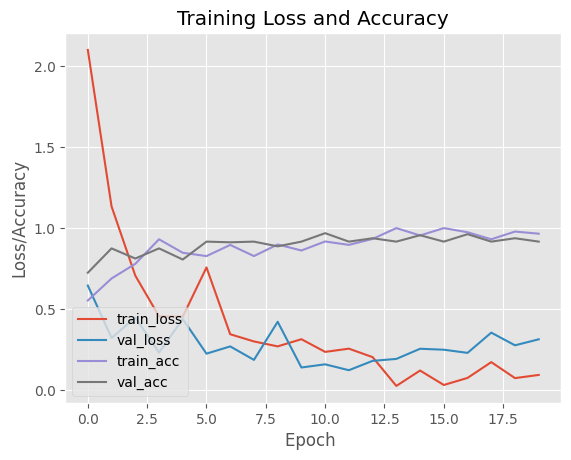

In [51]:
# Plot training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

TESTING


In [52]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('/Users/mr.aarmhanphyo/Documents/Robotics & AI/Final Year Project/AI_Model/MobileNetv2Testing /Plant_Disease_Detection_Model.keras')

In [53]:
# Define the class names (adjust based on your dataset)
class_names = ['Black Spot', 'Downy Mildew', 'Fresh Leaf']  # Update with your classes

In [54]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume 'model' is already loaded and 'class_names' is defined.

def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get index of the highest probability
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    return predicted_class_name, confidence


In [55]:
def test_model(folder_path, num_samples=10):
    true_labels = []
    predicted_labels = []
    confidences = []
    
    # Walk through the folder to collect images and true labels
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
        random.shuffle(images)  # Shuffle images
        selected_images = images[:num_samples]  # Select a subset for testing
        
        for img_path in selected_images:
            predicted_class, confidence = predict_image(img_path)
            true_labels.append(class_name)  # Ground truth from folder name
            predicted_labels.append(predicted_class)
            confidences.append(confidence)
    
    # Calculate overall accuracy
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    accuracy = correct / len(true_labels)
    return accuracy, true_labels, predicted_labels, confidences

In [56]:
def plot_results(true_labels, predicted_labels, confidences):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Confidence Scores
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(confidences)), confidences, color='skyblue')
    plt.xlabel('Test Images')
    plt.ylabel('Confidence')
    plt.title('Confidence Scores of Predictions')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

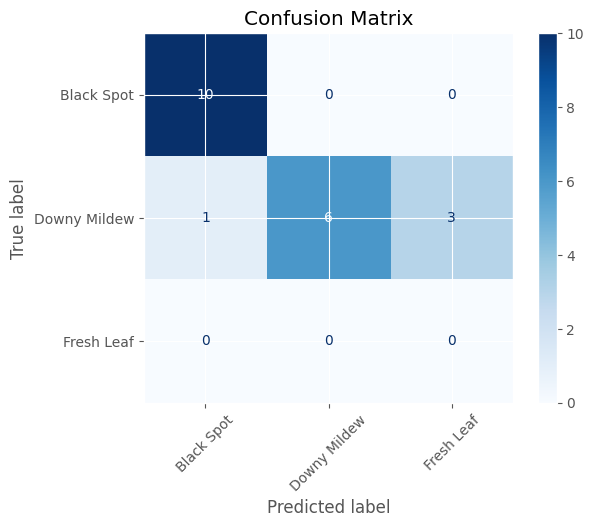

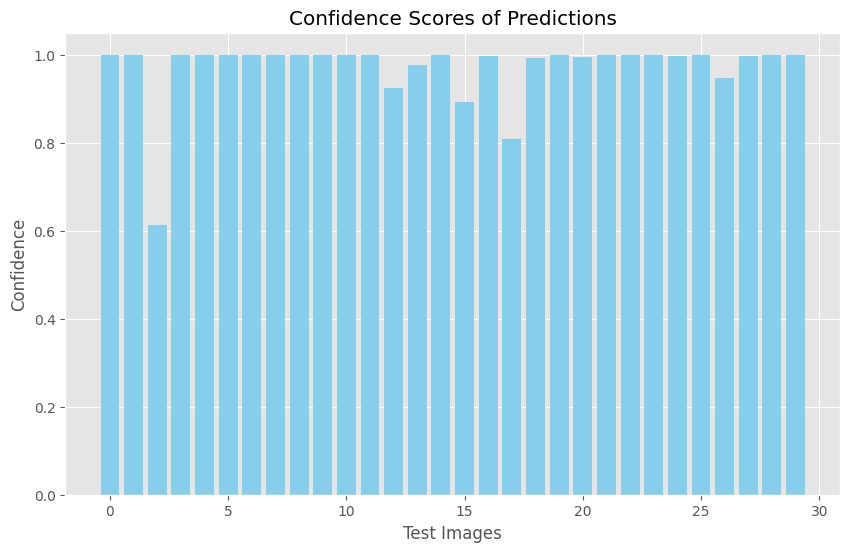

In [ ]:
# Example usage
folder_path = 'folder_path_to_val_folder'  # Replace with your dataset folder path
num_samples_per_class = 10

accuracy, true_labels, predicted_labels, confidences = test_model(folder_path, num_samples=num_samples_per_class)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

for true, pred, conf in zip(true_labels, predicted_labels, confidences):
    print(f'True: {true} | Predicted: {pred} | Confidence: {conf:.2f}')

plot_results(true_labels, predicted_labels, confidences)


In [ ]:
def manual_predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model's input shape
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get index of highest probability
    predicted_class_name = class_names[predicted_class_index]
    
    # Output result
    print(f"Predicted class: {predicted_class_name} with confidence {predictions[0][predicted_class_index]:.2f}")

# Path to the image you want to test
img_path = 'path_to_img.jpg'  # Replace with your test image path

#Predict
manual_predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: Black Spot with confidence 1.00
